# Hyper-parameter tuning – Friedman #3 Dataset  
This notebook finds the best parameters for:

* **Bagging** RandomForestRegressor  
* **Boosting** XGBRegressor  
* **Stack meta learner** Ridge α in the RF+XGB+OLS stack

Results are saved to `configs/` folder as yaml files.

## Setup & Imports

In [1]:
from joblib import parallel_backend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.model_selection import (
    RepeatedKFold,
    KFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.visualization import plot_optimization_history

from bagging_boosting_stacking_study.constants import SEED
from bagging_boosting_stacking_study.data.loaders import load_dataset
from bagging_boosting_stacking_study.configs import save_params, load_params

DATASET_NAME = "california_housing"

In [2]:
# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

## Load Clean Dataset

In [3]:
df = load_dataset(DATASET_NAME, raw=False)

### train test split

In [4]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)

In [5]:
train_df.shape

(18576, 18)

In [6]:
test_df.shape

(2064, 18)

## Bagging

### pipeline



### hyper-parameter tuning

In [7]:
# Split X and y (here X is a DataFrame)
y = train_df["target"].values
X = train_df.drop(columns="target")
n_features_total = X.shape[1]

# Cross-validation strategy: 10-fold, repeated three times
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)


# Objective function for Optuna
def objective(trial):
    # Hyper-parameter search space

    # (a) Ensemble size: bias keeps shrinking up to ~1 000 trees on 20k rows; >1 200
    # brings diminishing returns vs CPU.
    n_estimators = trial.suggest_int("n_estimators", 300, 900, step=150)

    # (b) Tree depth: depth-5 catches broad trends; depth-20 is usually enough to model
    # local price quirks. If CV prefers, let the forest grow un-capped (`None`).
    if trial.suggest_categorical("cap_depth", [True, False]):
        max_depth = trial.suggest_int("max_depth", 5, 20)
    else:
        max_depth = None

    # (c) Split regularisation: >=2 avoids one-sample splits; upper bound 20 keeps
    # leaves from fragmenting rare tracts.
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20, step=2)
    # >=1 leaf size trades variance (1) vs bias (10).
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # (d) Feature sub-sampling: at least 3 columns to keep engineered/interaction
    # features in play, at most the whole set.
    max_features = trial.suggest_int("max_features", 3, n_features_total)

    # (e) Row sub-sampling / bootstrap: bootstrapping decorrelates trees; try 50-100 %
    # of rows when enabled.
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_samples = (
        trial.suggest_float("max_samples", 0.5, 1.0, step=0.1) if bootstrap else None
    )

    # (f) Impurity criterion: compare classic MSE vs MAE (robust to coastal outliers).
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "absolute_error"]
    )
    # Cost-complexity pruning: 1e-6 ~ no pruning; 1e-2 is aggressive.
    ccp_alpha = trial.suggest_float("ccp_alpha", 1e-6, 1e-2, log=True)

    # (g) OOB score (only valid if bootstrap): can help the splitter choose less
    # over-fit parameters; tested as a flag.
    oob_score = bootstrap and trial.suggest_categorical("oob_score", [True, False])

    # Model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        max_samples=max_samples,
        criterion=criterion,
        ccp_alpha=ccp_alpha,
        oob_score=oob_score,
        n_jobs=1,
        random_state=SEED,
    )

    # CV evaluation (sklearn returns negative RMSE -> negate again to minimise)
    rmse = -cross_val_score(
        rf, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


study_rf = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),  # reproducible exploration
    pruner=HyperbandPruner(),  # early-stop weak configs
    study_name=f"RF_{DATASET_NAME}",
)

# Robust search: either n_trials or timeout
# study_rf.optimize(objective, n_trials=200, show_progress_bar=True)
study_rf.optimize(objective, timeout=60*30, show_progress_bar=True)

# Inspect the result
print("Best RMSE :", study_rf.best_value)
print("Best parameters:", study_rf.best_params)

[I 2025-05-26 19:43:20,562] A new study created in memory with name: RF_california_housing


   0%|          | 00:00/30:00

[I 2025-05-26 19:44:34,189] Trial 0 finished with value: 0.6222483989835678 and parameters: {'n_estimators': 800, 'cap_depth': True, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 4, 'bootstrap': False, 'criterion': 'squared_error', 'ccp_alpha': 1.7455220644664416e-06}. Best is trial 0 with value: 0.6222483989835678.
[I 2025-05-26 19:45:50,404] Trial 1 finished with value: 0.6054999892289274 and parameters: {'n_estimators': 400, 'cap_depth': True, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 17, 'bootstrap': True, 'max_samples': 0.7, 'criterion': 'squared_error', 'ccp_alpha': 1.4759234188486626e-06, 'oob_score': True}. Best is trial 1 with value: 0.6054999892289274.
[W 2025-05-26 20:23:36,415] Trial 2 failed with parameters: {'n_estimators': 1200, 'cap_depth': False, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 11, 'bootstrap': True, 'max_samples': 0.5, 'criterion': 'absolute_error', 'ccp_alpha': 8.4

KeyboardInterrupt: 

In [8]:
fig = plot_optimization_history(study_rf)
fig.show()

In [9]:
print("Best RMSE :", study_rf.best_value)

Best RMSE : 0.6054999892289274


In [10]:
study_rf.best_params

{'n_estimators': 400,
 'cap_depth': True,
 'max_depth': 11,
 'min_samples_split': 20,
 'min_samples_leaf': 5,
 'max_features': 17,
 'bootstrap': True,
 'max_samples': 0.7,
 'criterion': 'squared_error',
 'ccp_alpha': 1.4759234188486626e-06,
 'oob_score': True}

In [11]:
# Save best params to .yaml
save_params(DATASET_NAME, "rf", study_rf.best_value, study_rf.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\california_housing_rf.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/california_housing_rf.yaml')

In [12]:
best_rf_params = study_rf.best_params.copy()

cap_flag = best_rf_params.pop("cap_depth")  # True / False
max_depth = best_rf_params.pop("max_depth", None)  # may be absent
best_rf_params["max_depth"] = max_depth if cap_flag else None

best_rf_params.update(
    {
        "random_state": SEED,
        "n_jobs": -1,
    }
)

if not best_rf_params.get("bootstrap", False):
    best_rf_params["max_samples"] = None
    best_rf_params["oob_score"] = False  # safer to specify explicitly

# allowed = RandomForestRegressor().get_params().keys()
# best_rf_params = {k: v for k, v in best_rf_params.items() if k in allowed}

rf_final = RandomForestRegressor(**best_rf_params)
rf_final.fit(train_df.drop(columns="target"), train_df["target"])

RandomForestRegressor(ccp_alpha=1.4759234188486626e-06, max_depth=11,
                      max_features=17, max_samples=0.7, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=400, n_jobs=-1,
                      oob_score=True, random_state=333)

## Boosting

In [13]:
y = train_df["target"].values
X = train_df.drop(columns="target")

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)


def objective(trial):
    # (a) Ensemble size: bias keeps shrinking until ~2 000 trees; step 200 keeps search
    # grid compact.
    n_estimators = trial.suggest_int("n_estimators", 200, 2000, step=200)

    # (b) Learning rate: 0.01 allows large n_estimators; 0.3 speeds depth-wise models
    # when the tree budget is small.
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)

    # (c) Growth policy – explore depth-wise vs leaf-wise.
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if grow_policy == "depthwise":
        # Depth 3–12: deeper trees OK with 20k rows.
        max_depth = trial.suggest_int("max_depth", 3, 12)
        max_leaves = 0  # ignored in depthwise
    else:  # lossguide
        max_depth = 0  # ignored in lossguide
        # Leaves cap 32–256 keeps memory in check.
        max_leaves = trial.suggest_int("max_leaves", 32, 256, step=32)

    # (d) Child-weight: 0.5–20 smooths noisy rural tracts but still lets splits through
    # dense city areas.
    min_child_weight = trial.suggest_float("min_child_weight", 0.5, 20.0, log=True)

    # (e) Row / column subsampling:
    # - row 0.6–1.0  (>=12k rows/tree).
    # - column 0.6–1.0  (>=15 of 24 features).
    subsample = trial.suggest_float("subsample", 0.6, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1)

    # (f) Regularisation:
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 50.0, log=True)  # L2
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 15.0)  # L1
    gamma = trial.suggest_float("gamma", 0.0, 5.0)  # min-split-loss

    # (g) Max-delta-step:
    max_delta_step = trial.suggest_int("max_delta_step", 0, 5)

    # Model
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_leaves=max_leaves,
        grow_policy=grow_policy,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        max_delta_step=max_delta_step,
        objective="reg:squarederror",
        tree_method="hist",  # fast & deterministic on CPU
        random_state=SEED,
        n_jobs=1,
    )

    # CV evaluation (sklearn returns –RMSE -> negate)
    rmse = -cross_val_score(
        xgb, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()
    return rmse


study_xgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=HyperbandPruner(),  # cuts weak configs quickly
    study_name=f"XGB_{DATASET_NAME}",
)

study_xgb.optimize(objective, n_trials=200, show_progress_bar=True)

print("Best RMSE :", study_xgb.best_value)
print("Best parameters:", study_xgb.best_params)

[I 2025-05-26 20:25:40,211] A new study created in memory with name: XGB_california_housing


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-26 20:25:44,490] Trial 0 finished with value: 0.5655291441232226 and parameters: {'n_estimators': 1200, 'learning_rate': 0.119329717868809, 'grow_policy': 'lossguide', 'max_leaves': 96, 'min_child_weight': 0.5975240288011816, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_lambda': 0.014227965841598801, 'reg_alpha': 13.102340316882163, 'gamma': 0.2580581965137452, 'max_delta_step': 0}. Best is trial 0 with value: 0.5655291441232226.
[I 2025-05-26 20:25:49,057] Trial 1 finished with value: 0.5730565937028201 and parameters: {'n_estimators': 600, 'learning_rate': 0.019993480767036637, 'grow_policy': 'lossguide', 'max_leaves': 256, 'min_child_weight': 2.7989574433276676, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 2.587870367125735, 'reg_alpha': 7.2634301181348695, 'gamma': 0.634305168972219, 'max_delta_step': 0}. Best is trial 0 with value: 0.5655291441232226.
[I 2025-05-26 20:25:51,598] Trial 2 finished with value: 0.5872328561676201 and parameters: {'n_estimator

In [14]:
fig = plot_optimization_history(study_xgb)
fig.show()

In [15]:
print("Best RMSE:", study_xgb.best_value)

Best RMSE: 0.5555870831421031


In [16]:
study_xgb.best_params

{'n_estimators': 1200,
 'learning_rate': 0.014562414208702372,
 'grow_policy': 'lossguide',
 'max_leaves': 128,
 'min_child_weight': 2.7472005252618814,
 'subsample': 0.9,
 'colsample_bytree': 0.6,
 'reg_lambda': 0.18644737880752021,
 'reg_alpha': 4.679204693291257,
 'gamma': 0.18391510356680496,
 'max_delta_step': 2}

In [17]:
# Save best params to .yaml
save_params(DATASET_NAME, "xgb", study_xgb.best_value, study_xgb.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\california_housing_xgb.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/california_housing_xgb.yaml')

In [18]:
best_params = study_xgb.best_params.copy()

if best_params["grow_policy"] == "depthwise":
    best_params.pop("max_leaves", None)  # depthwise ignores leaf cap
else:  # lossguide
    best_params.pop("max_depth", None)  # drop if Optuna left a stub
    best_params["max_depth"] = 0  # explicit noop for leaf-wise

best_params.update(
    {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "random_state": SEED,
        "n_jobs": -1,
    }
)

# allowed = XGBRegressor().get_params().keys()
# best_params = {k: v for k, v in best_params.items() if k in allowed}

xgb_final = XGBRegressor(**best_params)
xgb_final.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.18391510356680496,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.014562414208702372,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=2, max_depth=0, max_leaves=128,
             min_child_weight=2.7472005252618814, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1200,
             n_jobs=-1, num_parallel_tree=None, ...)

## Stacking

In [19]:
y = train_df["target"].values
X = train_df.drop(columns="target")

# Random-Forest base learner
rf_best = load_params(dataset=DATASET_NAME, model="rf")["params"].copy()

cap_flag = rf_best.pop("cap_depth", None)
if cap_flag is not None:
    rf_best["max_depth"] = rf_best.pop("max_depth", None) if cap_flag else None

if not rf_best.get("bootstrap", False):
    rf_best["max_samples"] = None
    rf_best["oob_score"] = False

rf_best.update(dict(random_state=SEED, n_jobs=-1))
rf_pipeline = Pipeline([("rf", RandomForestRegressor(**rf_best))])

# XGBoost base learner
xgb_best = load_params(dataset=DATASET_NAME, model="xgb")["params"].copy()

if xgb_best.get("grow_policy", "depthwise") == "depthwise":
    xgb_best.pop("max_leaves", None)
else:  # lossguide
    xgb_best["max_depth"] = 0

xgb_best.update(
    dict(objective="reg:squarederror", tree_method="hist", random_state=SEED, n_jobs=-1)
)
xgb_pipeline = Pipeline([("xgb", XGBRegressor(**xgb_best))])

# OLS (with scaling)
ols_pipeline = Pipeline(
    [
        ("sc", StandardScaler()),
        ("ols", LinearRegression(n_jobs=-1)),
    ]
)

base_estimators = [
    ("rf", rf_pipeline),
    ("xgb", xgb_pipeline),
    ("ols", ols_pipeline),
]

# Out-of-fold predictions for Ridge meta-learner; 10-fold CV -> ~2 064 rows per fold
cv = KFold(n_splits=10, shuffle=True, random_state=SEED)

preds = []
with parallel_backend("loky"):  # respects n_jobs inside
    for name, est in tqdm(base_estimators, desc="OOF learners"):
        oof = cross_val_predict(est, X, y, cv=cv, n_jobs=-1, verbose=0)
        preds.append(oof)

X_meta = np.column_stack(preds)

# RidgeCV meta-learner
alphas = np.concatenate(([0.0], np.logspace(-8, 2, 500)))
ridge_cv = RidgeCV(
    alphas=alphas, cv=cv, scoring="neg_root_mean_squared_error", store_cv_results=False
).fit(X_meta, y)

best_alpha = ridge_cv.alpha_
best_rmse = np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))

print(f"Chosen alpha: {best_alpha:.4g}")
print(f"OOF RMSE    : {best_rmse:.5f}")

OOF learners:   0%|          | 0/3 [00:00<?, ?it/s]

Chosen alpha: 0
OOF RMSE    : 0.55208


In [20]:
print(f"Best RMSE: {np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))}")

Best RMSE: 0.5520757257799054


In [21]:
print(f"Best lambda (alpha): {ridge_cv.alpha_}")

Best lambda (alpha): 0.0


In [22]:
# Save best params to .yaml
save_params(
    dataset=DATASET_NAME, 
    model="stack", 
    metric=np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta))), 
    params={"alpha": float(ridge_cv.alpha_)}
)

Params saved to src\bagging_boosting_stacking_study\configs\california_housing_stack.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/california_housing_stack.yaml')

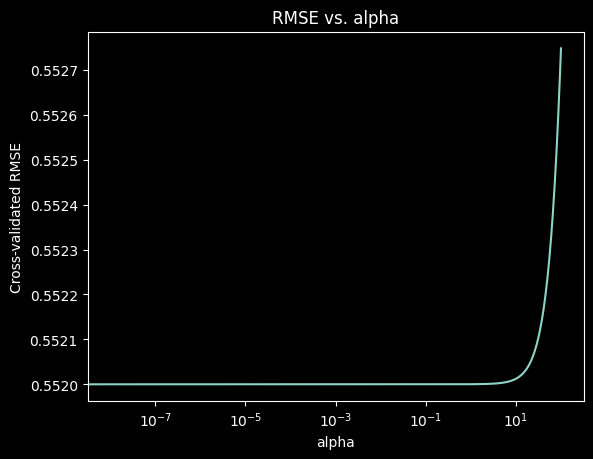

In [23]:
rmses = []
for a in alphas:
    scores = cross_val_score(
        Ridge(alpha=a),
        X_meta,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    rmses.append(-scores.mean())

plt.figure()
plt.xscale("log")
plt.plot(alphas, rmses)
plt.xlabel("alpha")
plt.ylabel("Cross-validated RMSE")
plt.title("RMSE vs. alpha")
plt.show()

In [24]:
alphas[np.argmin(rmses)]

np.float64(0.0)

In [25]:
best_alpha = ridge_cv.alpha_
meta_final = Pipeline(
    steps=[
        ("sc", StandardScaler()),
        (
            "ridge",
            Ridge(
                alpha=best_alpha,
                random_state=SEED,
            ),
        ),
    ]
)

# full stacking model
stack_final = StackingRegressor(
    estimators=base_estimators,  # rf_pipeline, xgb_pipeline, ols_pipeline
    final_estimator=meta_final,
    cv=cv,  # same 10-fold KFold
    passthrough=False,
    n_jobs=-1,
)
stack_final.fit(X, y)

StackingRegressor(cv=KFold(n_splits=10, random_state=333, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('rf',
                                                RandomForestRegressor(ccp_alpha=1.4759234188486626e-06,
                                                                      max_depth=11,
                                                                      max_features=17,
                                                                      max_samples=0.7,
                                                                      min_samples_leaf=5,
                                                                      min_samples_split=20,
                                                                      n_estimators=400,
                                                                      n_jobs=-1,
                                                                      oob_score=True,
                                                                      random_state=333))])),
                              ('xgb',
                               Pipeline(steps=[('xgb',
                                                XGBReg...
                                                             min_child_weight=2.7472005252618814,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1200,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None, ...))])),
                              ('ols',
                               Pipeline(steps=[('sc', StandardScaler()),
                                               ('ols',
                                                LinearRegression(n_jobs=-1))]))],
                  final_estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                  ('ridge',
                                                   Ridge(alpha=np.float64(0.0),
                                                         random_state=333))]),
                  n_jobs=-1)